# XGBoost Recommendation model

Import packages

In [1]:
%matplotlib inline
import time
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pylab as plt
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load data

In [2]:
dtrain = pd.read_csv('Data/dtrain_cleaned.csv')
dtest = pd.read_csv('Data/dtest_cleaned.csv')

In [3]:
dtrain.describe()

,Unnamed: 0,AktorId,Alder,FylkeNr,KommuneNr,Postnr,ErDisponentAnt,ErKontoapnerAnt,ErKausjonistAnt,ErRealkausjonistAnt,...,AntSparekonto,AntAktiveSkadefors,AntAktiv_AndreForsikringer,AntAktUtlanAvt,AntAvtBSU,AntAktBoliglan,DNBAntAktBoliglan,AntAktGaranterte,AntAktLink,AntAktSpareforsikring
count,3630.000000,3.630000e+03,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,...,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000
mean,2508.213774,3.218082e+06,43.208815,7.695868,783.614325,3613.719008,0.300551,0.055923,0.000551,0.014601,...,0.701653,0.102479,0.102204,0.178512,0.107713,0.176584,0.045455,0.044077,0.011846,0.201377
std,1431.680916,2.104151e+06,14.468157,5.738833,576.161533,2556.014909,0.458561,0.229804,0.023469,0.119964,...,0.457596,0.303319,0.302958,0.382996,0.310061,0.381369,0.208328,0.205295,0.108206,0.401085
min,0.000000,9.380000e+02,18.000000,1.000000,101.000000,168.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1284.500000,1.548604e+06,31.000000,3.000000,301.000000,1453.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2512.500000,2.712668e+06,43.000000,6.000000,621.500000,3124.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3731.500000,4.479664e+06,55.000000,12.000000,1201.000000,5229.750000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4998.000000,9.424479e+06,70.000000,20.000000,2030.000000,9990.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
dtrain = dtrain.drop('Unnamed: 0',1)
dtest = dtest.drop('Unnamed: 0',1)

Set identifier and target variables

In [5]:
ID_col = 'AktorId'
target_cols = ['AntAktAvtBank',
 'AntAktAvtInnskudd',
 'AntAktAvtKredittkort',
 'AntKredittkortDebet',
 'AntKredittkortKreditt',
 'AntSparekonto',
 'AntBrukskonto',
 'AntAvtBSU',
 'AntAktiveSkadefors',
 'AntAktiv_AndreForsikringer',
 'AntAktSpareforsikring',
 'AntAktUtlanAvt',
 'AntAktBoliglan',
 'DNBAntAktBoliglan',
 'AntAktGaranterte',
 'AntAktLink']

Define function for creating XGBoost models and perform cross-validation

In [ ]:
id_preds = defaultdict(list)

def modelfit(alg, dtrain, dtest, target_cols, useTrainCV=True, cv_folds=5, early_stopping_rounds=50, 
             plotImportance=False,reports=False):
    
    dtrain_acc_lst=[]
    dtrain_roc_auc_lst=[]
    dtest_acc_lst=[]
    dtest_roc_auc_lst=[]
    
    ids = dtest['AktorId'].values
    
    time_train=0
    time_test=0
    for target in target_cols:
        # Choose all predictors except target & IDcols
        predictors = [x for x in dtrain.columns if x not in [target, ID_col]]
        
        t0_train = time.time()
        if useTrainCV:
            xgb_param = alg.get_xgb_params()
            xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
            cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                metrics='auc', early_stopping_rounds=early_stopping_rounds)
            alg.set_params(n_estimators=cvresult.shape[0])

        # Fit the algorithm on the data
        alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')

        # Predict training set
        dtrain_predictions = alg.predict(dtrain[predictors])
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        t1_train = time.time()
        diff_time_train = t1_train-t0_train
        time_train+=diff_time_train

        # Predict test set
        t0_test = time.time()
        dtest_predictions = alg.predict(dtest[predictors])
        dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
        t1_test = time.time()
        diff_time_test = t1_test-t0_test
        time_test+=diff_time_test
        
        for id, p in zip(ids, dtest_predprob):
            id_preds[id].append(p)
            
        # Accuracy training set
        dtrain_acc = metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
        dtrain_roc_auc = metrics.roc_auc_score(dtrain[target], dtrain_predprob)

        dtrain_acc_lst.append(dtrain_acc)
        dtrain_roc_auc_lst.append(dtrain_roc_auc)
    
        # Accuracy test set
        dtest_acc = metrics.accuracy_score(dtest[target].values, dtest_predictions)
        dtest_roc_auc = metrics.roc_auc_score(dtest[target], dtest_predprob)
        
        dtest_acc_lst.append(dtest_acc)
        dtest_roc_auc_lst.append(dtest_roc_auc)
        
        # Print model report:
        print ('\nModel Report: ', target)
        print ('Accuracy (Train): %.4g' % dtrain_acc)
        print ('AUC Score (Train): %.4g' % dtrain_roc_auc)
        print ('Accuracy (Test): %.4g' % dtest_acc)
        print ('AUC Score (Test): %.4g' % dtest_roc_auc)
        print('Optimal number of boosting trees: %d' % cvresult.shape[0])
        
        if(reports==True):
            report_train = classification_report(dtrain[target].values,dtrain_predictions)
            print(report_train)
            cm_train = confusion_matrix(dtrain[target].values,dtrain_predictions)
            print(cm_train)
            
            report_test = classification_report(dtest[target].values,dtest_predictions)
            print(report_test)
            cm_test = confusion_matrix(dtest[target].values,dtest_predictions)
            print(cm_test)
        
        if (plotImportance==True):
            title = 'Feature importance: '+str(target)
            xgb.plot_importance(alg, ax=None, height=0.2, xlim=None, ylim=None, title=title, 
                            xlabel='F score', ylabel='Features', importance_type='weight', max_num_features=None, 
                            grid=True)
     
    
    # Average accuracy scores
    dtrain_avg_acc = np.average(dtrain_acc_lst)
    dtrain_avg_roc_auc = np.average(dtrain_roc_auc_lst)
    dtest_avg_acc = np.average(dtest_acc_lst)
    dtest_avg_roc_auc = np.average(dtest_roc_auc_lst)
    
    print('\nAverage accuracy (Train): %.4g' % dtrain_avg_acc)
    print('Average AUC score (Train): %.4g' % dtrain_avg_roc_auc)
    print('Average accuracy (Test): %.4g' % dtest_avg_acc)
    print('Average AUC score (Test): %.4g' % dtest_avg_roc_auc)
    
    print('Prediction time train %.4g' % time_train)
    print('Prediction time test %.4g' % time_test)

Set the initial boosting parameters

In [7]:
xgb1 = XGBClassifier(
 learning_rate=0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

Fit a set of XGBoost models for each target variable

In [8]:
modelfit(xgb1, dtrain, dtest, target_cols)


Model Report:  AntAktAvtBank
Accuracy (Train): 0.9959
AUC Score (Train): 0.9999
Accuracy (Test): 0.9901
AUC Score (Test): 0.9986
Optimal number of boosting trees: 63

Model Report:  AntAktAvtInnskudd
Accuracy (Train): 0.9978
AUC Score (Train): 0.9999
Accuracy (Test): 0.9967
AUC Score (Test): 0.9993
Optimal number of boosting trees: 10

Model Report:  AntAktAvtKredittkort
Accuracy (Train): 0.8716
AUC Score (Train): 0.9393
Accuracy (Test): 0.8488
AUC Score (Test): 0.923
Optimal number of boosting trees: 10

Model Report:  AntKredittkortDebet
Accuracy (Train): 1
AUC Score (Train): 1
Accuracy (Test): 1
AUC Score (Test): 1
Optimal number of boosting trees: 10

Model Report:  AntKredittkortKreditt
Accuracy (Train): 0.9584
AUC Score (Train): 0.9275
Accuracy (Test): 0.9603
AUC Score (Test): 0.8836
Optimal number of boosting trees: 10

Model Report:  AntSparekonto
Accuracy (Train): 0.9744
AUC Score (Train): 0.997
Accuracy (Test): 0.9727
AUC Score (Test): 0.9963
Optimal number of boosting trees

#### Hyperparameter tuning

Tune max_depth and min_child_weight

In [9]:
param_test1 = [{
 'max_depth':[3,5,7,9,11],
 'min_child_weight':[1,3,5,7]
}]

gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,n_estimators=63,max_depth=5,
                                                  min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,
                                                  objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27), 
                        param_grid=param_test1,scoring='roc_auc',n_jobs=1,iid=False,cv=5)

target = 'AntAktAvtBank'
predictors = [x for x in dtrain.columns if x not in [target,ID_col]]
gsearch1.fit(dtrain[predictors],dtrain[target])
gsearch1.grid_scores_,gsearch1.best_params_,gsearch1.best_score_

([mean: 0.99750, std: 0.00093, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.99707, std: 0.00142, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.99711, std: 0.00126, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.99688, std: 0.00129, params: {'max_depth': 3, 'min_child_weight': 7},
  mean: 0.99800, std: 0.00097, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.99706, std: 0.00141, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.99704, std: 0.00135, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.99691, std: 0.00150, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: 0.99793, std: 0.00103, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.99715, std: 0.00144, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.99709, std: 0.00135, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.99691, std: 0.00150, params: {'max_depth': 7, 'min_child_weight': 7},
  mean: 0.99800, std: 0.00106, params: {

In [10]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[0,1,2]
}
gsearch2 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,n_estimators=63,max_depth=5,
                                                  min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,
                                                  objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27),
                        param_grid=param_test2,scoring='roc_auc',n_jobs=1,iid=False,cv=5)
gsearch2.fit(dtrain[predictors],dtrain[target])
gsearch2.grid_scores_,gsearch2.best_params_,gsearch2.best_score_

([mean: 0.99785, std: 0.00085, params: {'max_depth': 4, 'min_child_weight': 0},
  mean: 0.99777, std: 0.00079, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.99752, std: 0.00108, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.99789, std: 0.00083, params: {'max_depth': 5, 'min_child_weight': 0},
  mean: 0.99800, std: 0.00097, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.99765, std: 0.00108, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.99792, std: 0.00066, params: {'max_depth': 6, 'min_child_weight': 0},
  mean: 0.99790, std: 0.00107, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.99761, std: 0.00114, params: {'max_depth': 6, 'min_child_weight': 2}],
 {'max_depth': 5, 'min_child_weight': 1},
 0.9979983529567505)

We get the optimum values as 5 for max_depth and 1 for min_child_weight, thus the CV score in unchanged. Note that as the model performance increases, it becomes exponentially difficult to achieve even marginal gains in performance.

Tune gamma

In [11]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,11)]
}
gsearch3 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,n_estimators=63,max_depth=5,
                                                  min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,
                                                  objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27), 
                        param_grid=param_test3,scoring='roc_auc',n_jobs=1,iid=False,cv=5)
gsearch3.fit(dtrain[predictors],dtrain[target])
gsearch3.grid_scores_,gsearch3.best_params_,gsearch3.best_score_

([mean: 0.99800, std: 0.00097, params: {'gamma': 0.0},
  mean: 0.99803, std: 0.00089, params: {'gamma': 0.1},
  mean: 0.99803, std: 0.00090, params: {'gamma': 0.2},
  mean: 0.99810, std: 0.00092, params: {'gamma': 0.3},
  mean: 0.99801, std: 0.00093, params: {'gamma': 0.4},
  mean: 0.99801, std: 0.00087, params: {'gamma': 0.5},
  mean: 0.99802, std: 0.00080, params: {'gamma': 0.6},
  mean: 0.99803, std: 0.00078, params: {'gamma': 0.7},
  mean: 0.99799, std: 0.00077, params: {'gamma': 0.8},
  mean: 0.99795, std: 0.00083, params: {'gamma': 0.9},
  mean: 0.99790, std: 0.00088, params: {'gamma': 1.0}],
 {'gamma': 0.3},
 0.9981022059604495)

Gamma=0.3 is the optimal value. Before proceeding we re-calibrate the number of boosting rounds for the updated parameters.

In [12]:
xgb2 = XGBClassifier(
 learning_rate=0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb2, dtrain, dtest, target_cols)


Model Report:  AntAktAvtBank
Accuracy (Train): 0.9975
AUC Score (Train): 1
Accuracy (Test): 0.9884
AUC Score (Test): 0.9987
Optimal number of boosting trees: 87

Model Report:  AntAktAvtInnskudd
Accuracy (Train): 0.9975
AUC Score (Train): 0.9999
Accuracy (Test): 0.995
AUC Score (Test): 0.9992
Optimal number of boosting trees: 14

Model Report:  AntAktAvtKredittkort
Accuracy (Train): 0.8744
AUC Score (Train): 0.942
Accuracy (Test): 0.8471
AUC Score (Test): 0.9248
Optimal number of boosting trees: 14

Model Report:  AntKredittkortDebet
Accuracy (Train): 1
AUC Score (Train): 1
Accuracy (Test): 1
AUC Score (Test): 1
Optimal number of boosting trees: 14

Model Report:  AntKredittkortKreditt
Accuracy (Train): 0.9584
AUC Score (Train): 0.9292
Accuracy (Test): 0.9603
AUC Score (Test): 0.885
Optimal number of boosting trees: 14

Model Report:  AntSparekonto
Accuracy (Train): 0.9738
AUC Score (Train): 0.9975
Accuracy (Test): 0.9727
AUC Score (Test): 0.9964
Optimal number of boosting trees: 14



Here we observe improvement in the scores. The final parameters are:
* max_depth: 5
* min_child_weight: 1
* gamma: 0.3

Tune subsample and colsample_bytree

In [13]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}
gsearch4 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,n_estimators=87,max_depth=5,
                                                  min_child_weight=1,gamma=0.3,subsample=0.8,colsample_bytree=0.8,
                                                  objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27),
                        param_grid=param_test4,scoring='roc_auc',n_jobs=1,iid=False,cv=5)
gsearch4.fit(dtrain[predictors],dtrain[target])
gsearch4.grid_scores_,gsearch4.best_params_,gsearch4.best_score_

([mean: 0.99764, std: 0.00091, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.99770, std: 0.00090, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.99765, std: 0.00087, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.99791, std: 0.00070, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.99792, std: 0.00061, params: {'colsample_bytree': 0.6, 'subsample': 1.0},
  mean: 0.99764, std: 0.00114, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.99781, std: 0.00103, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.99770, std: 0.00088, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.99784, std: 0.00083, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.99778, std: 0.00066, params: {'colsample_bytree': 0.7, 'subsample': 1.0},
  mean: 0.99780, std: 0.00098, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.99794, std: 0.00097, params: {'colsample_bytree': 0.8, 'subsample'

In [14]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(85,100,5)]
}
gsearch5 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,n_estimators=87,max_depth=5,
                                                  min_child_weight=1,gamma=0.3,subsample=0.8,colsample_bytree=0.9,
                                                  objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27), 
                        param_grid=param_test5,scoring='roc_auc',n_jobs=1,iid=False,cv=5)
gsearch5.fit(dtrain[predictors],dtrain[target])
gsearch5.grid_scores_,gsearch5.best_params_,gsearch5.best_score_

([mean: 0.99818, std: 0.00088, params: {'colsample_bytree': 0.85, 'subsample': 0.75},
  mean: 0.99808, std: 0.00097, params: {'colsample_bytree': 0.85, 'subsample': 0.8},
  mean: 0.99804, std: 0.00098, params: {'colsample_bytree': 0.85, 'subsample': 0.85},
  mean: 0.99799, std: 0.00096, params: {'colsample_bytree': 0.9, 'subsample': 0.75},
  mean: 0.99815, std: 0.00098, params: {'colsample_bytree': 0.9, 'subsample': 0.8},
  mean: 0.99793, std: 0.00097, params: {'colsample_bytree': 0.9, 'subsample': 0.85},
  mean: 0.99813, std: 0.00094, params: {'colsample_bytree': 0.95, 'subsample': 0.75},
  mean: 0.99806, std: 0.00103, params: {'colsample_bytree': 0.95, 'subsample': 0.8},
  mean: 0.99790, std: 0.00086, params: {'colsample_bytree': 0.95, 'subsample': 0.85}],
 {'colsample_bytree': 0.85, 'subsample': 0.75},
 0.998177974162728)

The optimum values are:
* subsample: 0.75
* colsample_bytree: 0.85

Tuning Regularization Parameters

In [15]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,n_estimators=87,max_depth=5,
                                                  min_child_weight=1,gamma=0.3,subsample=0.75,colsample_bytree=0.85,
                                                  objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27),
                        param_grid=param_test6,scoring='roc_auc',n_jobs=1,iid=False,cv=5)
gsearch6.fit(dtrain[predictors],dtrain[target])
gsearch6.grid_scores_,gsearch6.best_params_,gsearch6.best_score_

([mean: 0.99803, std: 0.00097, params: {'reg_alpha': 1e-05, 'reg_lambda': 1e-05},
  mean: 0.99804, std: 0.00097, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.01},
  mean: 0.99810, std: 0.00093, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.1},
  mean: 0.99818, std: 0.00088, params: {'reg_alpha': 1e-05, 'reg_lambda': 1},
  mean: 0.99526, std: 0.00170, params: {'reg_alpha': 1e-05, 'reg_lambda': 100},
  mean: 0.99797, std: 0.00110, params: {'reg_alpha': 0.01, 'reg_lambda': 1e-05},
  mean: 0.99803, std: 0.00101, params: {'reg_alpha': 0.01, 'reg_lambda': 0.01},
  mean: 0.99808, std: 0.00099, params: {'reg_alpha': 0.01, 'reg_lambda': 0.1},
  mean: 0.99806, std: 0.00085, params: {'reg_alpha': 0.01, 'reg_lambda': 1},
  mean: 0.99525, std: 0.00171, params: {'reg_alpha': 0.01, 'reg_lambda': 100},
  mean: 0.99799, std: 0.00100, params: {'reg_alpha': 0.1, 'reg_lambda': 1e-05},
  mean: 0.99804, std: 0.00106, params: {'reg_alpha': 0.1, 'reg_lambda': 0.01},
  mean: 0.99809, std: 0.00094, params: {'reg

In [16]:
param_test7 = {
 'reg_alpha':[0.000001,0.000005,0.00001,0.00005,0.0001],
 'reg_lambda':[0.3,0.5,1,1.5,3,5,10,20]
}
gsearch7 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,n_estimators=87,max_depth=5,
                                                  min_child_weight=1,gamma=0.3,subsample=0.75,colsample_bytree=0.85,
                                                  objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27), 
                        param_grid=param_test7,scoring='roc_auc',n_jobs=1,iid=False,cv=5)
gsearch7.fit(dtrain[predictors],dtrain[target])
gsearch7.grid_scores_,gsearch7.best_params_,gsearch7.best_score_

([mean: 0.99818, std: 0.00087, params: {'reg_alpha': 1e-06, 'reg_lambda': 0.3},
  mean: 0.99789, std: 0.00097, params: {'reg_alpha': 1e-06, 'reg_lambda': 0.5},
  mean: 0.99818, std: 0.00088, params: {'reg_alpha': 1e-06, 'reg_lambda': 1},
  mean: 0.99800, std: 0.00079, params: {'reg_alpha': 1e-06, 'reg_lambda': 1.5},
  mean: 0.99797, std: 0.00086, params: {'reg_alpha': 1e-06, 'reg_lambda': 3},
  mean: 0.99788, std: 0.00077, params: {'reg_alpha': 1e-06, 'reg_lambda': 5},
  mean: 0.99760, std: 0.00100, params: {'reg_alpha': 1e-06, 'reg_lambda': 10},
  mean: 0.99720, std: 0.00090, params: {'reg_alpha': 1e-06, 'reg_lambda': 20},
  mean: 0.99818, std: 0.00087, params: {'reg_alpha': 5e-06, 'reg_lambda': 0.3},
  mean: 0.99789, std: 0.00097, params: {'reg_alpha': 5e-06, 'reg_lambda': 0.5},
  mean: 0.99818, std: 0.00088, params: {'reg_alpha': 5e-06, 'reg_lambda': 1},
  mean: 0.99800, std: 0.00079, params: {'reg_alpha': 5e-06, 'reg_lambda': 1.5},
  mean: 0.99797, std: 0.00086, params: {'reg_alpha

Apply the optimal regularization in the model and look at the impact:

In [24]:
xgb3 = XGBClassifier(
 learning_rate=0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0.3,
 subsample=0.75,
 colsample_bytree=0.85,
 reg_alpha=0.000001,
 reg_lambda=0.3,
 objective='binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb3, dtrain, dtest, target_cols,reports=True)


Model Report:  AntAktAvtBank
Accuracy (Train): 0.9959
AUC Score (Train): 0.9999
Accuracy (Test): 0.9909
AUC Score (Test): 0.9985
Optimal number of boosting trees: 58
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       383
          1       1.00      1.00      1.00      3247

avg / total       1.00      1.00      1.00      3630

[[ 383    0]
 [  15 3232]]
             precision    recall  f1-score   support

          0       0.93      0.99      0.96       126
          1       1.00      0.99      0.99      1084

avg / total       0.99      0.99      0.99      1210

[[ 125    1]
 [  10 1074]]

Model Report:  AntAktAvtInnskudd
Accuracy (Train): 0.9986
AUC Score (Train): 1
Accuracy (Test): 0.9967
AUC Score (Test): 0.9996
Optimal number of boosting trees: 58
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       277
          1       1.00      1.00      1.00      3353

avg / total       1.00

/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Model Report:  AntSparekonto
Accuracy (Train): 0.9631
AUC Score (Train): 0.9946
Accuracy (Test): 0.9661
AUC Score (Test): 0.9954
Optimal number of boosting trees: 1
             precision    recall  f1-score   support

          0       0.91      0.98      0.94      1083
          1       0.99      0.96      0.97      2547

avg / total       0.97      0.96      0.96      3630

[[1059   24]
 [ 110 2437]]
             precision    recall  f1-score   support

          0       0.92      0.97      0.94       341
          1       0.99      0.97      0.98       869

avg / total       0.97      0.97      0.97      1210

[[330  11]
 [ 30 839]]

Model Report:  AntBrukskonto
Accuracy (Train): 0.981
AUC Score (Train): 0.9974
Accuracy (Test): 0.9736
AUC Score (Test): 0.9958
Optimal number of boosting trees: 1
             precision    recall  f1-score   support

          0       0.96      0.96      0.96       852
          1       0.99      0.99      0.99      2778

avg / total       0.98      

We can see that the score is slightly reduced from the previous score. This is due to the fact that the parameters are only optimized for the first product.

Reducing the learning rate


Model Report:  AntAktAvtBank
Accuracy (Train): 0.9917
AUC Score (Train): 0.9997
Accuracy (Test): 0.9893
AUC Score (Test): 0.9981
Optimal number of boosting trees: 278

Model Report:  AntAktAvtInnskudd
Accuracy (Train): 0.9975
AUC Score (Train): 0.9999
Accuracy (Test): 0.9959
AUC Score (Test): 0.9993
Optimal number of boosting trees: 59

Model Report:  AntAktAvtKredittkort
Accuracy (Train): 0.8636
AUC Score (Train): 0.9404
Accuracy (Test): 0.8421
AUC Score (Test): 0.9249
Optimal number of boosting trees: 59

Model Report:  AntKredittkortDebet
Accuracy (Train): 1
AUC Score (Train): 1
Accuracy (Test): 1
AUC Score (Test): 1
Optimal number of boosting trees: 1

Model Report:  AntKredittkortKreditt
Accuracy (Train): 0.9592
AUC Score (Train): 0.823
Accuracy (Test): 0.9603
AUC Score (Test): 0.8052
Optimal number of boosting trees: 1

Model Report:  AntSparekonto
Accuracy (Train): 0.9631
AUC Score (Train): 0.9946
Accuracy (Test): 0.9661
AUC Score (Test): 0.9954
Optimal number of boosting trees

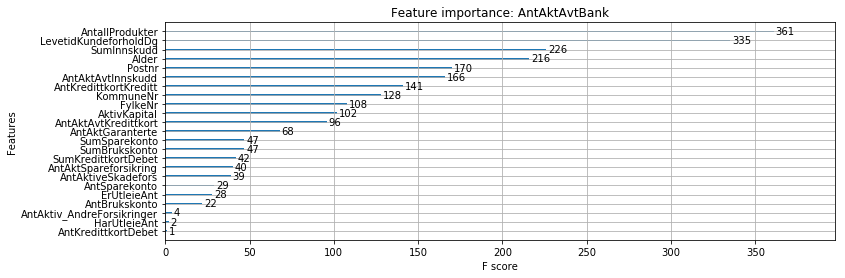

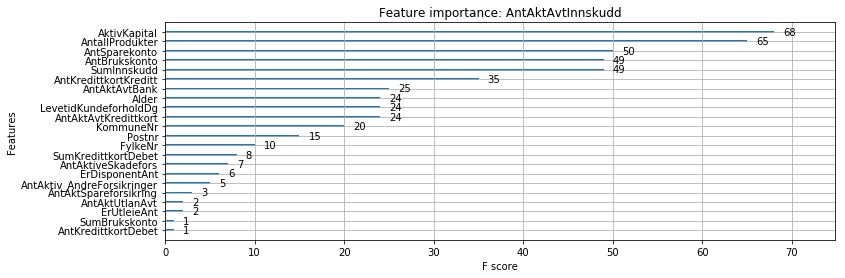

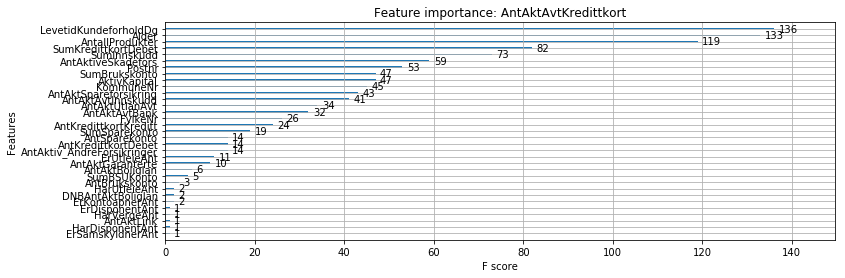

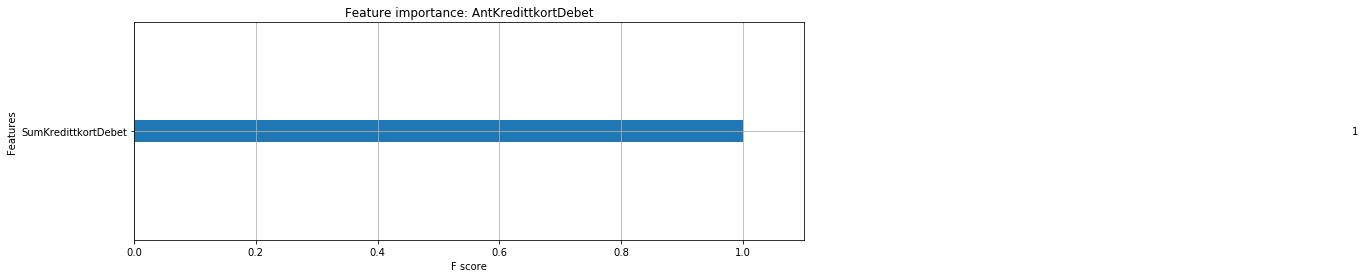

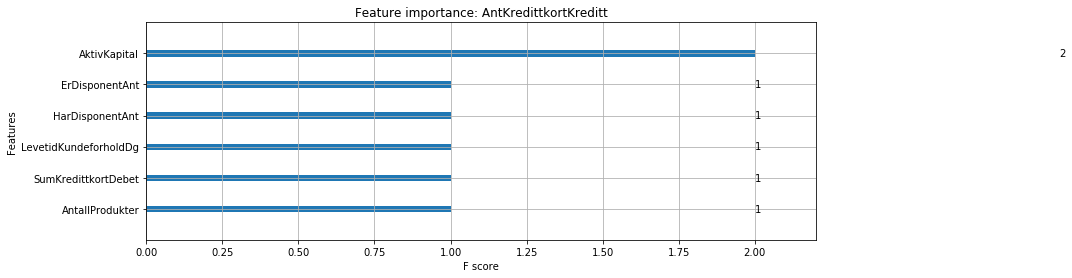

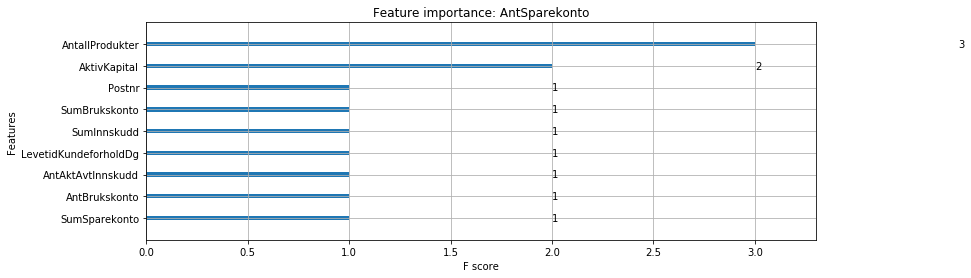

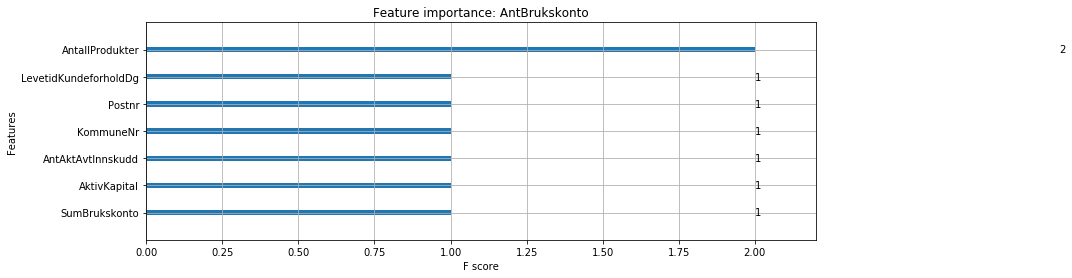

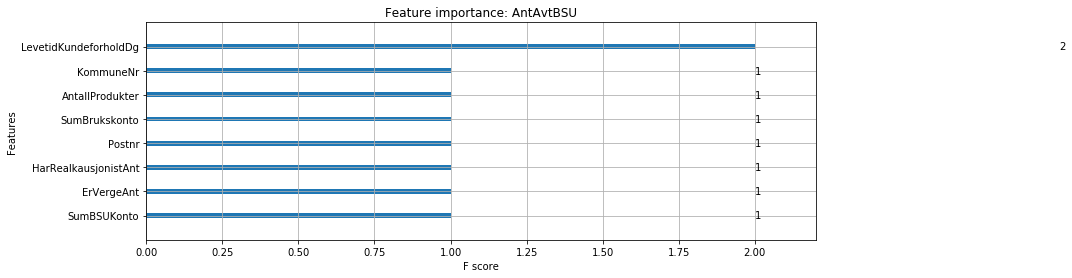

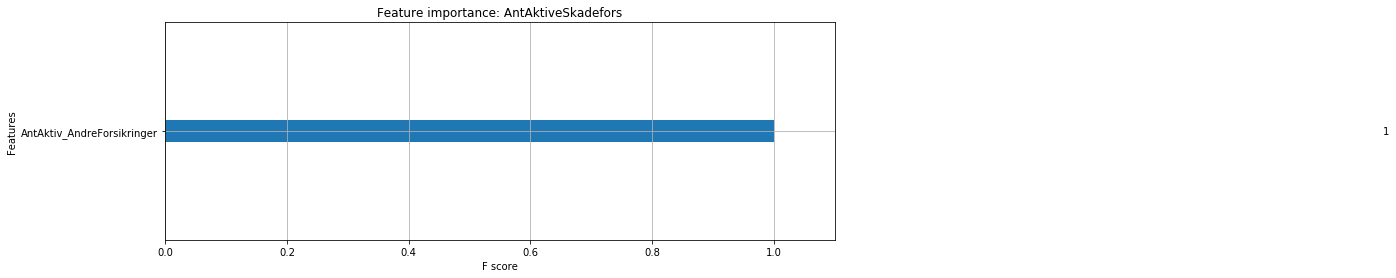

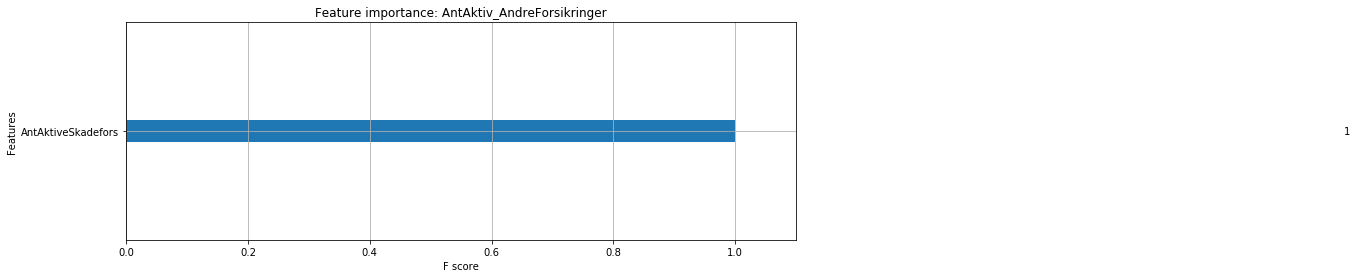

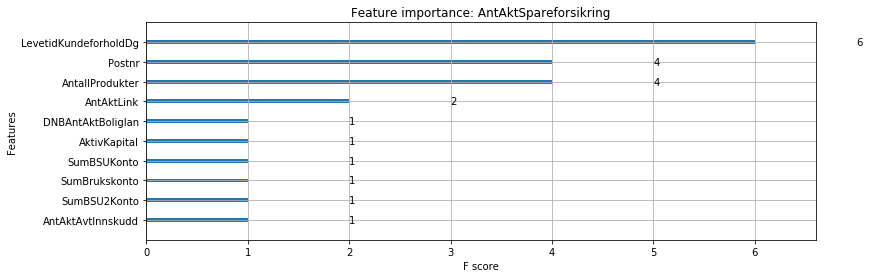

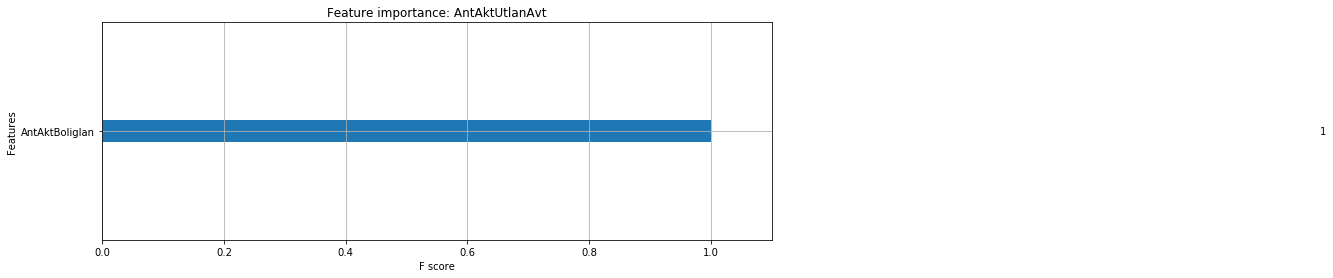

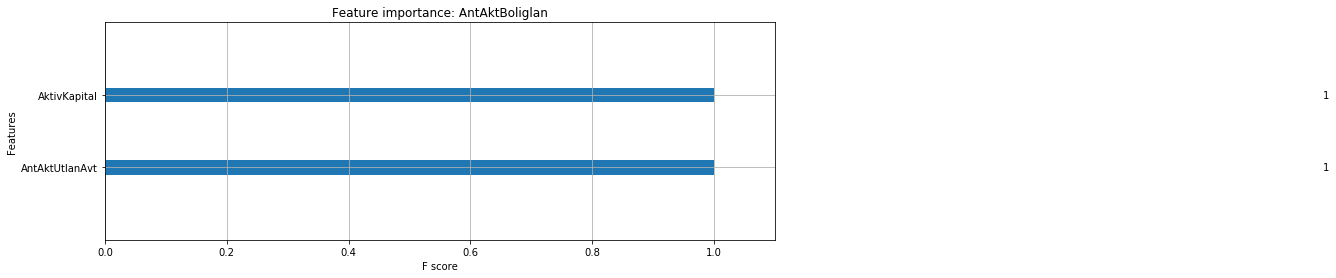

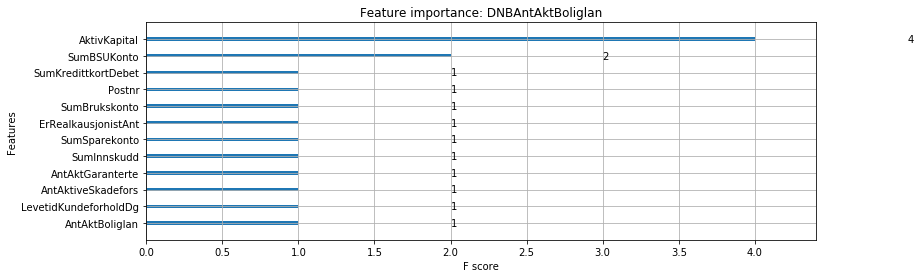

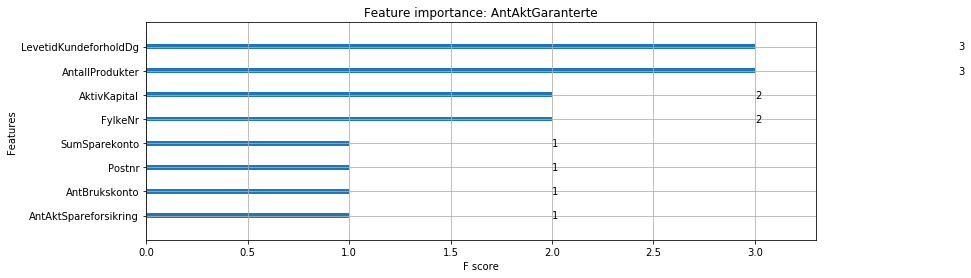

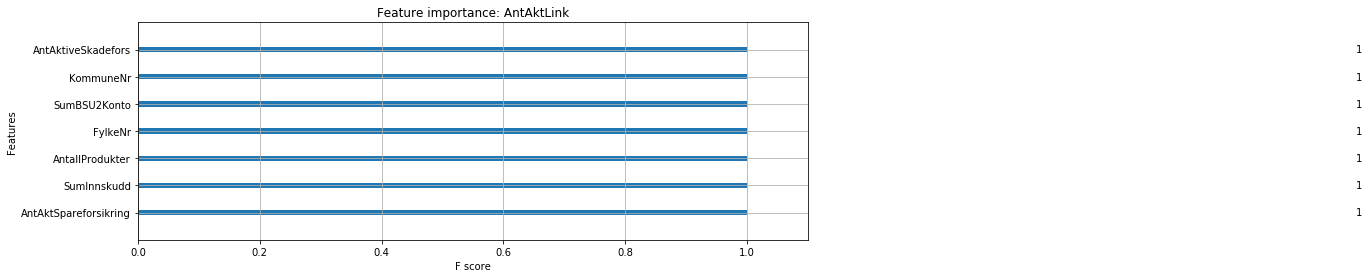

In [18]:
xgb4 = XGBClassifier(
 learning_rate=0.01,
 n_estimators=5000,
 max_depth=5,
 min_child_weight=1,
 gamma=0.3,
 subsample=0.75,
 colsample_bytree=0.85,
 reg_alpha=0.000001,
 reg_lambda=0.3,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

id_preds = defaultdict(list)

modelfit(xgb4, dtrain, dtest, target_cols, plotImportance=True)

Make recommendations for customers in test set (3 products not currently active)

In [19]:
dtest_id = dtest[ID_col]
dtest_target = dtest[target_cols]
dtest_matrix = pd.concat([dtest_id, dtest_target], axis=1)

In [20]:
# List the products that the customer already have
already_active = {}
for row in dtest_matrix.values:
    row = list(row)
    id = row.pop(0)
    active = [c[0] for c in zip(dtest_matrix.columns[1:], row) if c[1] > 0]
    already_active[id] = active

# Sort the predicted products that are not already active by their probability 
test_preds = {}
for id, p in id_preds.items():
    preds = [i[0] for i in sorted([i for i in zip(dtest_matrix.columns[1:], p) if i[0] not in already_active[id]], 
                                  key=lambda i:i [1], reverse=True)[:3]]
    test_preds[id] = preds

# Get the recommended products for all customers in test set
test_recommendations = []
sample_id = []
for row in dtest_matrix.values:
    id = row[0]
    sample_id.append(id)
    p = test_preds[id]
    test_recommendations.append(' '.join(p))

Save recommendations to csv file

In [21]:
sample=pd.DataFrame(({'AktorId':sample_id,'Added Product':test_recommendations}))
sample.to_csv('Results/XGBoost_recommendations.csv',index=False)

In [22]:
sample

,Added Product,AktorId
0,AntAktSpareforsikring AntKredittkortKreditt An...,8611310
1,AntAktSpareforsikring AntAvtBSU AntKredittkort...,8983279
2,AntAktSpareforsikring AntAvtBSU AntKredittkort...,8514183
3,AntAktSpareforsikring AntAvtBSU AntBrukskonto,3650156
4,AntAktSpareforsikring AntAvtBSU AntBrukskonto,3806766
5,AntAktSpareforsikring AntAvtBSU AntAktUtlanAvt,3964722
6,AntAktSpareforsikring AntAvtBSU AntKredittkort...,4866025
7,AntAvtBSU AntAktSpareforsikring AntKredittkort...,1892555
8,AntAktSpareforsikring AntAvtBSU AntBrukskonto,3700667
9,AntAktSpareforsikring AntAvtBSU AntBrukskonto,2694529
